<a href="https://colab.research.google.com/github/szilaard/AIT2023/blob/main/AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2021 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlretrieve
import numpy as np
import random
import sys
import re, cgi
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
!pip install tika

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from tika import parser

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [4]:

!wget https://mek.oszk.hu/00700/00708/00708.pdf -O jozsef.pdf
text1 = parser.from_file('jozsef.pdf')
jozsefData=text1['content']



!wget https://mek.oszk.hu/00500/00597/00597.pdf -O arany.pdf
text2 = parser.from_file('arany.pdf')
aranyData=text2['content']


--2023-04-19 12:07:12--  https://mek.oszk.hu/00700/00708/00708.pdf
Resolving mek.oszk.hu (mek.oszk.hu)... 193.6.201.253, 2001:738:0:306::2
Connecting to mek.oszk.hu (mek.oszk.hu)|193.6.201.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1609063 (1.5M) [application/pdf]
Saving to: ‘jozsef.pdf’

jozsef.pdf          100%[===================>]   1.53M  1.94MB/s    in 0.8s    

2023-04-19 12:07:14 (1.94 MB/s) - ‘jozsef.pdf’ saved [1609063/1609063]

--2023-04-19 12:07:16--  https://mek.oszk.hu/00500/00597/00597.pdf
Resolving mek.oszk.hu (mek.oszk.hu)... 193.6.201.253, 2001:738:0:306::2
Connecting to mek.oszk.hu (mek.oszk.hu)|193.6.201.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4332687 (4.1M) [application/pdf]
Saving to: ‘arany.pdf’

arany.pdf           100%[===================>]   4.13M  2.73MB/s    in 1.5s    

2023-04-19 12:07:18 (2.73 MB/s) - ‘arany.pdf’ saved [4332687/4332687]



In [5]:
jozsefData=jozsefData[110500:] # the first part of the text was a summary with a lot of .... lines so i cut them out of the dataset
aranyData=aranyData[300000:900000]  #I shortened the data, because the ram ran out in colab, and this way we have comparable amount of data from both authors
#jozsefData=jozsefData[110500:400000] 
#aranyData=aranyData[300000:600000]
print(len(aranyData))
print(len(jozsefData))

600000
556749


## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

In [6]:
chars1 = sorted(list(set(aranyData)))
print('Unique characters in Arany Janos:', len(chars1))
chars2 = sorted(list(set(jozsefData)))
print('Unique characters in Jozsef Attila:', len(chars2))
charsAll = sorted(list(set(aranyData+jozsefData)))
print(len(charsAll))



Unique characters in Arany Janos: 108
Unique characters in Jozsef Attila: 108
115


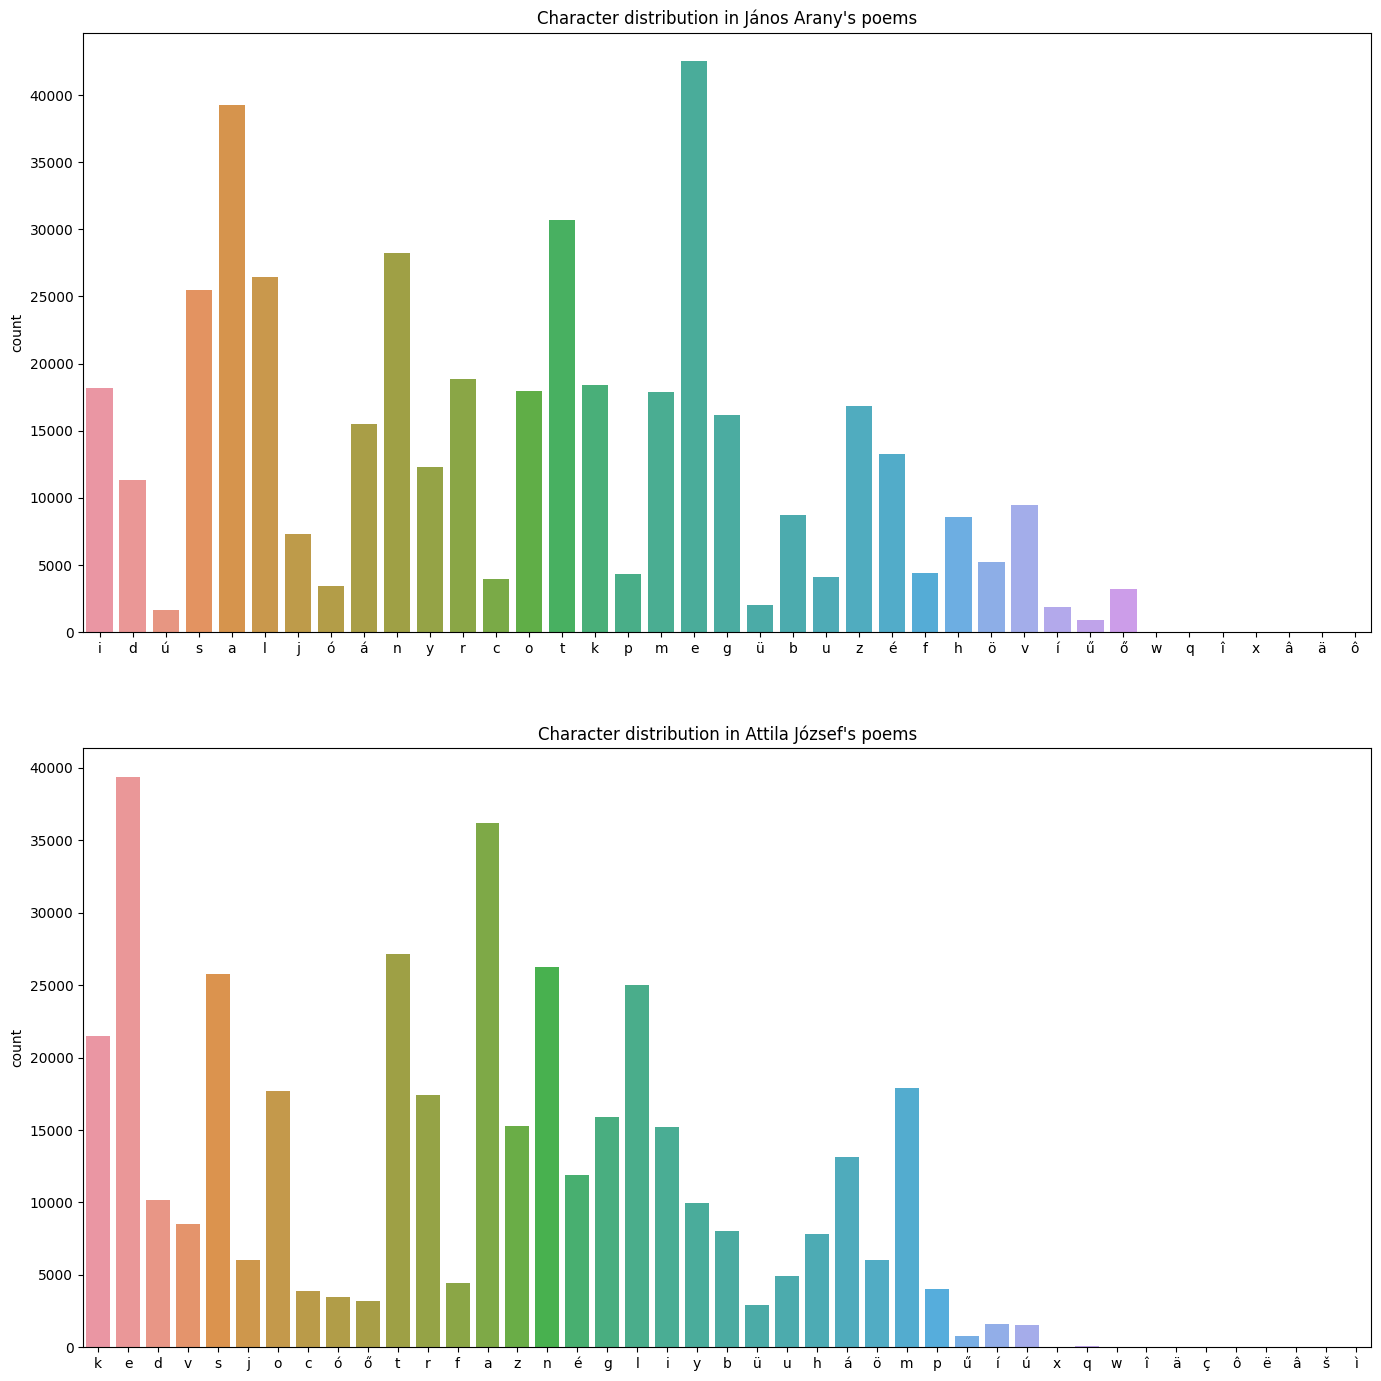

In [55]:
#betuk_arany=[i for i in aranyData if i.isalpha()]
betuk_arany=[]
for i in list(aranyData):
  if i.isalpha():
    betuk_arany.append(i.lower())

betuk_jozsef=[]
for i in list(jozsefData):
  if i.isalpha():
    betuk_jozsef.append(i.lower())


fig, ax = plt.subplots(2, 1, figsize=(15, 15))
sns.countplot(x=betuk_arany,ax=ax[0]).set(title="Character distribution in János Arany's poems")
sns.countplot(x=betuk_jozsef,ax=ax[1]).set(title="Character distribution in Attila József's poems")
fig.tight_layout(pad=5.0)
fig.show()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [7]:
char_indices = dict((c, i) for i, c in enumerate(charsAll))
indices_char = dict((i, c) for i, c in enumerate(charsAll))

In [8]:
maxlen  = 60
step    = 20   # the step size between two "sentence" is 10 characters
# I tried different dataset sizes, because i had problem with colabs ram limit. I tried reducing the original data, and i got bad results with that
# after that i tried incresing the step size and with that the results were much better
aranySentences  = [] # maxlen number of characters, with "step" overlap between two "sentences" 
arany_next_chars = [] # the next character
jozsefSentences=[]
jozsef_next_chars=[]



In [9]:
for i in range(0, len(jozsefData)-maxlen, step):
    jozsefSentences.append(jozsefData[i:i+maxlen])

for i in range(0, len(aranyData)-maxlen, step):
    aranySentences.append(aranyData[i:i+maxlen])

In [10]:
X_arany = np.zeros((len(aranySentences), maxlen,len(charsAll)))
y_arany = np.zeros((len(aranySentences), 1))
X_jozsef = np.zeros((len(jozsefSentences), maxlen,len(charsAll)))
y_jozsef = np.zeros((len(jozsefSentences), 1))

In [11]:
for i, sentence in enumerate(aranySentences):
    for t, char in enumerate(sentence): 
        X_arany[i,t,char_indices[char]] = 1
    y_arany[i] = 0

for i, sentence in enumerate(jozsefSentences):
    for t, char in enumerate(sentence): 
        X_jozsef[i,t,char_indices[char]] = 1
    y_jozsef[i] = 1

print ("Shape of the input data:", X_arany.shape)
print ("Shape of the target data:", y_arany.shape)

Shape of the input data: (29997, 60, 115)
Shape of the target data: (29997, 1)


## Data splitting
Split the data into train, validate and test sets. Make 

In [12]:
train_split = 0.7
valid_split=0.9
train_split_ind_arany=int(len(X_arany)*train_split)
train_split_ind_jozsef=int(len(X_jozsef)*train_split)
valid_split_ind_arany=int(len(X_arany)*valid_split)
valid_split_ind_jozsef=int(len(X_jozsef)*valid_split)
X_train = np.concatenate((X_jozsef[:train_split_ind_jozsef],X_arany[:train_split_ind_arany]))
Y_train = np.concatenate((y_jozsef[:train_split_ind_jozsef],y_arany[:train_split_ind_arany]))
X_test = np.concatenate((X_jozsef[train_split_ind_jozsef:valid_split_ind_jozsef],X_arany[train_split_ind_arany:valid_split_ind_arany]))
Y_test = np.concatenate((y_jozsef[train_split_ind_jozsef:valid_split_ind_jozsef],y_arany[train_split_ind_arany:valid_split_ind_arany]))
X_valid = np.concatenate((X_jozsef[valid_split_ind_jozsef:],X_arany[valid_split_ind_arany:]))
Y_valid = np.concatenate((y_jozsef[valid_split_ind_jozsef:],y_arany[valid_split_ind_arany:]))

In [13]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_valid.shape)
print(Y_valid.shape)

(40481, 60, 115)
(40481, 1)
(11567, 60, 115)
(11567, 1)
(5784, 60, 115)
(5784, 1)


## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [14]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[-2], X_train.shape[-1])))
model.add(Dense(1))
model.add(Activation('sigmoid'))   #softmax ha 2 a dense sigmoid ha 1

In [15]:
es = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [16]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

## Model training
Train the model and apply early stopping.

In [17]:
history = model.fit(X_train, Y_train,
              batch_size=256,
              epochs=40,
              validation_data=(X_valid, Y_valid),
              verbose=1, 
              callbacks=es)

Epoch 1/40
159/159 [==============================] - 67s 401ms/step - loss: 0.5804 - accuracy: 0.6888 - val_loss: 0.5090 - val_accuracy: 0.7688
Epoch 2/40
159/159 [==============================] - 64s 402ms/step - loss: 0.4911 - accuracy: 0.7613 - val_loss: 0.4985 - val_accuracy: 0.7758
Epoch 3/40
159/159 [==============================] - 63s 398ms/step - loss: 0.4362 - accuracy: 0.7983 - val_loss: 0.4583 - val_accuracy: 0.8152
Epoch 4/40
159/159 [==============================] - 64s 397ms/step - loss: 0.3746 - accuracy: 0.8337 - val_loss: 0.4183 - val_accuracy: 0.8339
Epoch 5/40
159/159 [==============================] - 65s 411ms/step - loss: 0.3484 - accuracy: 0.8476 - val_loss: 0.3806 - val_accuracy: 0.8456
Epoch 6/40
159/159 [==============================] - 63s 398ms/step - loss: 0.3265 - accuracy: 0.8583 - val_loss: 0.3404 - val_accuracy: 0.8589
Epoch 7/40
159/159 [==============================] - 65s 411ms/step - loss: 0.3053 - accuracy: 0.8679 - val_loss: 0.3594 - val_ac

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [18]:
preds = model.predict(X_test)
round_preds= np.rint(preds)

362/362 [==============================] - 15s 40ms/step


In [20]:
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc

In [21]:
print("Accuracy:",accuracy_score(Y_test, round_preds))
print("Precision:",precision_score(Y_test, round_preds, average='macro'))
print("Recall:",recall_score(Y_test, round_preds, average='macro'))
print("F1:",f1_score(Y_test, round_preds, average='macro'))

Accuracy: 0.9090516123454655
Precision: 0.9089504758859119
Recall: 0.9088850967007964
F1: 0.9089168039896327


In [22]:
result=model.evaluate(X_test,Y_test)

362/362 [==============================] - 20s 56ms/step - loss: 0.2333 - accuracy: 0.9091


## Confusion matrix
Calculate and display the confusion matrix.

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

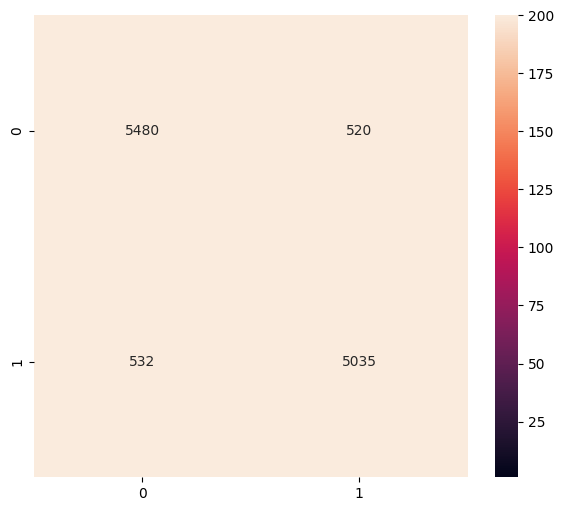

In [24]:
conf = confusion_matrix(Y_test, round_preds)
plt.figure(figsize=(7,6))
sns.heatmap(conf, fmt='d', annot=True, vmin=1, vmax=200)